In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import importlib
import attrs

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline

In [3]:
X, y = attrs.dataset_loader()

In [4]:
X.shape

(27558, 50, 50, 3)

Text(0.5, 1.0, 'Parasitized')

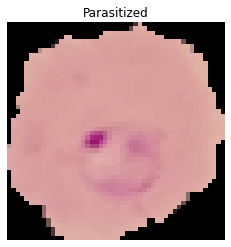

In [5]:
plt.imshow(X[y == 1][0])
plt.axis("off")
plt.title("Parasitized")

Text(0.5, 1.0, 'Not Parasitized')

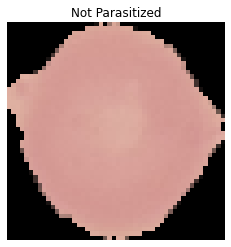

In [6]:
plt.imshow(X[y == 0][0])
plt.axis("off")
plt.title("Not Parasitized")

e:\Program files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

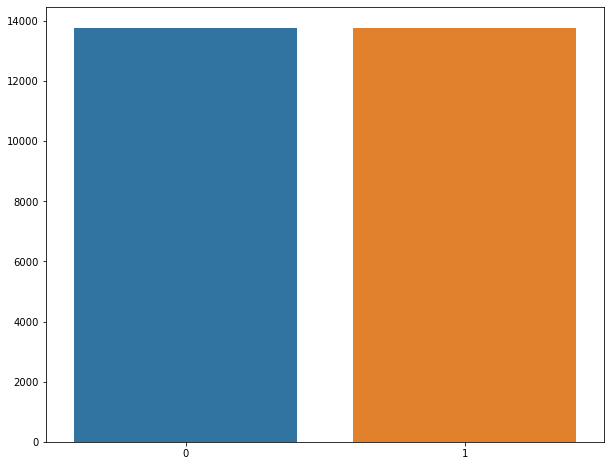

In [7]:
unique, count = np.unique(y, return_counts=True)
plt.figure(figsize=(10,8))
sns.barplot(unique, y=count)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

x_train shape:  (22046, 50, 50, 3)
x_test shape:  (5512, 50, 50, 3)
y_train shape:  (22046,)
y_test shape:  (5512,)


### ML models

In [ ]:
pipeline = Pipeline([
    ("ravel_array", attrs.ArrayRavel())
])
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.fit_transform(X_test)

In [ ]:
# using random forest classifer is like using svm like this: svc_clf = SVC(C=1000, kernel="rbf", gamma=0.1)
# SVM takes a very long time to train and check for cross validation.
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=24, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(max_leaf_nodes=24, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [ ]:
rnd_scores = attrs.cross_val_score(rnd_clf, X_train_prepared, y_train, n=15)
attrs.display_cross_val_score(rnd_scores)

Scores:  [0.72472784 0.72472784 0.718507   0.72706065 0.71772939 0.7192846
 0.70917574 0.70995334 0.718507   0.7192846  0.73250389 0.718507
 0.72939347 0.70451011 0.73172628]
Mean:  0.7203732503888024
Standard deviation:  0.007939190680000123


- RandomForest is severly underfitting the dataset

In [ ]:
# let's try ada boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=8), n_estimators=500, algorithm="SAMME.R", random_state=42, learning_rate=0.5)
ada_clf.fit(X_train_prepared, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=8),
                   learning_rate=0.5, n_estimators=500, random_state=42)

In [ ]:
ada_scores = attrs.cross_val_score(ada_clf, X_train_prepared, y_train, n=15)
attrs.display_cross_val_score(ada_scores)

In [ ]:
importlib.reload(attrs)

<module 'attrs' from 'd:\\Machine learning\\Projects\\Malaria Cell Predictor\\attrs.py'>

In [ ]:
import xgboost

xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train_prepared, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=4)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
              

In [ ]:
xgb_scores = attrs.cross_val_score(xgb_clf, X_train_prepared, y_train, n=15)
attrs.display_cross_val_score(xgb_scores)

Scores:  [0.63685848 0.62674961 0.63763608 0.6407465  0.63374806 0.64463453
 0.64774495 0.65163297 0.63530327 0.64852255 0.65007776 0.655521
 0.64385692 0.64930016 0.63608087]
Mean:  0.6425609123898394
Standard deviation:  0.0077587504132170726


### NN models

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
root_logdir = os.path.join(os.curdir, "logs")

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

def get_run_logdir(name=None):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") + f"- {name}"
    return os.path.join(root_logdir, run_id)

In [11]:
X_train_prepared, X_valid_prepared, y_train_prepared, y_valid_prepared = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
X_train_prepared.shape

(17636, 50, 50, 3)

### Model 1

In [13]:
nn_model = keras.Sequential()
nn_model.add(keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(50,50,3)))
nn_model.add(keras.layers.MaxPool2D(2))
nn_model.add(keras.layers.Dropout(0.2))

nn_model.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
nn_model.add(keras.layers.MaxPool2D(2,2))
nn_model.add(keras.layers.Dropout(0.3))

nn_model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
nn_model.add(keras.layers.MaxPool2D(2,2))
nn_model.add(keras.layers.Dropout(0.3))

nn_model.add(keras.layers.Flatten())
nn_model.add(keras.layers.Dense(64,activation='relu'))
nn_model.add(keras.layers.Dropout(0.5))

nn_model.add(keras.layers.Dense(1,activation='sigmoid'))

In [14]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/nn_model_1.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("nn_model_1"))

nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
history = nn_model.fit(X_train_prepared, y_train_prepared, 
                        epochs=30,
                        validation_data=(X_valid_prepared, y_valid_prepared),
                        callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
552/552 [==============================] - 10s 12ms/step - loss: 0.5164 - accuracy: 0.7418 - val_loss: 0.2115 - val_accuracy: 0.9177
Epoch 2/30
552/552 [==============================] - 5s 9ms/step - loss: 0.2370 - accuracy: 0.9126 - val_loss: 0.1845 - val_accuracy: 0.9342
Epoch 3/30
552/552 [==============================] - 5s 9ms/step - loss: 0.2153 - accuracy: 0.9254 - val_loss: 0.1760 - val_accuracy: 0.9454
Epoch 4/30
552/552 [==============================] - 5s 9ms/step - loss: 0.2014 - accuracy: 0.9310 - val_loss: 0.1718 - val_accuracy: 0.9463
Epoch 5/30
552/552 [==============================] - 5s 8ms/step - loss: 0.1975 - accuracy: 0.9358 - val_loss: 0.1976 - val_accuracy: 0.9354
Epoch 6/30
552/552 [==============================] - 5s 9ms/step - loss: 0.1946 - accuracy: 0.9364 - val_loss: 0.1669 - val_accuracy: 0.9449
Epoch 7/30
552/552 [==============================] - 5s 9ms/step - loss: 0.1817 - accuracy: 0.9414 - val_loss: 0.1615 - val_accuracy: 0.9483
Epoc

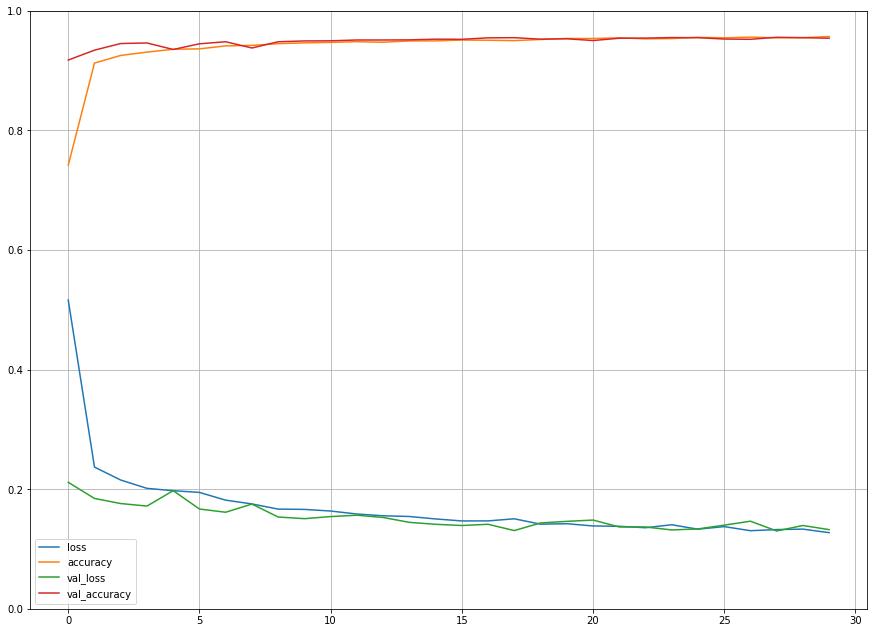

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
nn_model.evaluate(X_test, y_test)

173/173 [==============================] - 1s 5ms/step - loss: 0.1449 - accuracy: 0.9550


[0.14489613473415375, 0.9550072550773621]

### Model 2

In [18]:
nn_model_2 = keras.Sequential()
nn_model_2.add(keras.layers.Conv2D(16, 7, activation='relu', padding="same", input_shape=(50,50,3)))
nn_model_2.add(keras.layers.MaxPool2D(2))

nn_model_2.add(keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.MaxPool2D(2))

nn_model_2.add(keras.layers.Conv2D(64, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.Conv2D(64, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.MaxPool2D(2))

nn_model_2.add(keras.layers.Flatten())
nn_model_2.add(keras.layers.Dense(64, activation='relu'))
nn_model_2.add(keras.layers.Dropout(0.5))

nn_model_2.add(keras.layers.Dense(1, activation='sigmoid'))

In [19]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/nn_model_2.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("nn_model_2"))

nn_model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
history = nn_model_2.fit(X_train_prepared, y_train_prepared, 
                        epochs=50,
                        validation_data=(X_valid_prepared, y_valid_prepared),
                        callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/50
552/552 [==============================] - 10s 17ms/step - loss: 0.6921 - accuracy: 0.5168 - val_loss: 0.6775 - val_accuracy: 0.6052
Epoch 2/50
552/552 [==============================] - 6s 11ms/step - loss: 0.6812 - accuracy: 0.5667 - val_loss: 0.6524 - val_accuracy: 0.6122
Epoch 3/50
552/552 [==============================] - 6s 11ms/step - loss: 0.6582 - accuracy: 0.6149 - val_loss: 0.5765 - val_accuracy: 0.7222
Epoch 4/50
552/552 [==============================] - 6s 10ms/step - loss: 0.2800 - accuracy: 0.8946 - val_loss: 0.1711 - val_accuracy: 0.9426
Epoch 5/50
552/552 [==============================] - 6s 11ms/step - loss: 0.1647 - accuracy: 0.9457 - val_loss: 0.1517 - val_accuracy: 0.9531
Epoch 6/50
552/552 [==============================] - 6s 11ms/step - loss: 0.1501 - accuracy: 0.9519 - val_loss: 0.1323 - val_accuracy: 0.9574
Epoch 7/50
552/552 [==============================] - 6s 11ms/step - loss: 0.1348 - accuracy: 0.9568 - val_loss: 0.1255 - val_accuracy: 0.960

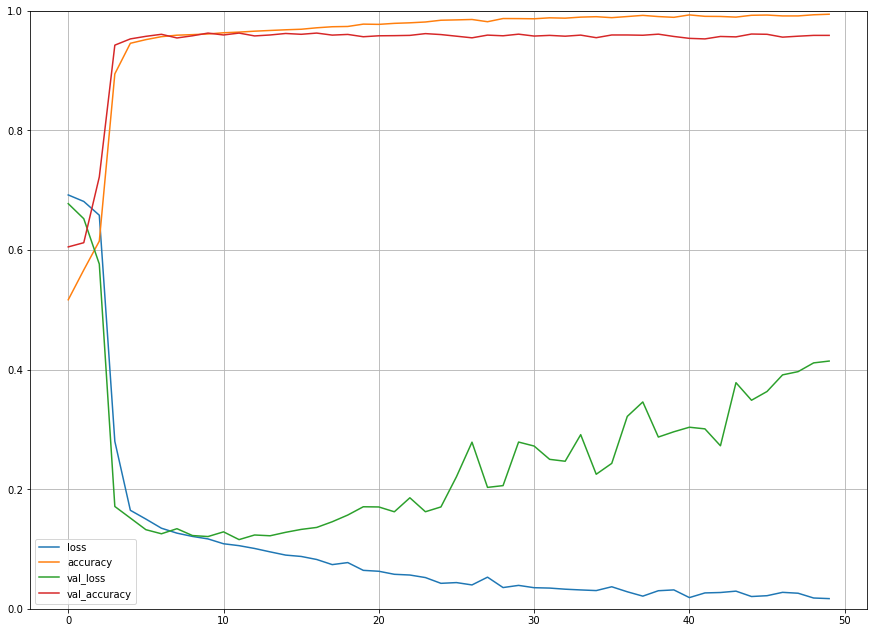

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [22]:
nn_model_2.evaluate(X_test, y_test)

173/173 [==============================] - 1s 5ms/step - loss: 0.5145 - accuracy: 0.9534


[0.5144659280776978, 0.953374445438385]

### Check

In [11]:
nn_model_1 = keras.models.load_model("models/nn_model_1.h5")
nn_model_1.evaluate(X_train, y_train), nn_model_1.evaluate(X_test, y_test)

173/173 [==============================] - 1s 4ms/step - loss: 0.1431 - accuracy: 0.9543


([0.1084483340382576, 0.9602649211883545],
 [0.14311763644218445, 0.9542815685272217])

In [12]:
nn_model_2 = keras.models.load_model("models/nn_model_2.h5")
nn_model_2.evaluate(X_train, y_train), nn_model_2.evaluate(X_test, y_test)

173/173 [==============================] - 1s 5ms/step - loss: 0.1304 - accuracy: 0.9570


([0.09157044440507889, 0.9681574702262878],
 [0.13042955100536346, 0.9570028781890869])

In [13]:
y_pred_1 = nn_model_1.predict(X_test)
y_pred_1 = np.round(y_pred_1)

y_pred_2 = nn_model_2.predict(X_test)
y_pred_2 = np.round(y_pred_2)

173/173 [==============================] - 1s 3ms/step


In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [15]:
[accuracy_score(y_test, y_pred_1), f1_score(y_test, y_pred_1)], [precision_score(y_test, y_pred_1), recall_score(y_test, y_pred_1)]

([0.9542815674891146, 0.9541984732824427],
 [0.9704251386321626, 0.9385055416517698])

In [16]:
[accuracy_score(y_test, y_pred_2), f1_score(y_test, y_pred_2)], [precision_score(y_test, y_pred_2), recall_score(y_test, y_pred_2)]

([0.9570029027576198, 0.956633119853614],
 [0.97976011994003, 0.9345727565248481])

In [ ]:
nn_model_2.save("models/best_nn_model.h5")